
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [16]:
import pandas as pd
import numpy as np
import torch

from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, BertModel

import matplotlib.pyplot as plt

In [3]:
#Dropout: 5%, 15%, 25%, 35%, and 50%
DROPOUT = 0.05

#Learning rate: 5e-4, 1e-3, 5e-3, 1e-2
LEARNING_RATE = 5e-4

In [18]:
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
#tokenizer = AutoTokenizer.from_pretrained("")
#model = AutoModel.from_pretrained("")

In [19]:
df = pd.read_csv('../datasets/buscape_preprocessed_balanced_cleared.csv')

In [20]:
df.head(3)

,review_text,rating
0,nao comparia novamente essa marca pois paguei ...,0
1,tem uma boa aderencia te da mas agilidades no ...,0
2,somente mais um jogo do estilo nada realmente ...,0


In [21]:
print(f'{df.shape[0]} instancias, {df.shape[1]} classes')

13620 instancias, 2 classes


#### Dividindo dataset em dois batchs, 50% cada

In [22]:
reviews_batch_01, reviews_batch_02, labels_batch_01, labels_batch_02 = train_test_split(df['review_text'], df['rating'], test_size=0.5, random_state=42)

In [23]:
print(f'batch_01: {reviews_batch_01.shape[0]} instancias')
print(f'batch_02: {reviews_batch_02.shape[0]} instancias')

batch_01: 6810 instancias
batch_02: 6810 instancias


#### Quantidade de avaliações positivas e negativas no batch_01

In [24]:
labels_batch_01.value_counts()

rating
1    3419
0    3391
Name: count, dtype: int64

In [25]:
reviews = reviews_batch_01
labels = labels_batch_01

#### Tokenização e geração dos embeddings
- Este processo pode demorar alguns instantes para ser concluído

In [26]:
embeddings = []
for review in reviews:
    inputs = tokenizer(review, return_tensors="pt", padding=True, truncation=True )
    with torch.no_grad():
        output = model(**inputs)
    embeddings.append(output.last_hidden_state.mean(dim=1).numpy())

In [27]:
embeddings_array = np.vstack(embeddings)

In [28]:
print(f'{embeddings_array.shape[0]} embeddings de {embeddings_array.shape[1]} dimensões')

6810 embeddings de 768 dimensões


#### Feature based 1

In [29]:
additional_features = np.array([[len(review.split())] for review in reviews_batch_02])

In [30]:
print(embeddings_array.shape)
print(additional_features.shape)

(6810, 768)
(6810, 1)


#### Combinando embeddings_array e additional_features

In [31]:
combined_features = np.hstack((embeddings_array, additional_features))

#### Dividindo dataset treino e teste

In [32]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

In [33]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [34]:
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

#### Arquitetura rede neural MLP

In [35]:
model = Sequential([
    Dense(24, activation='relu', input_dim=X_train_tensor.shape[1]),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                18480     
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 18,505
Trainable params: 18,505
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

#### Cross-validation

In [37]:
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

#### Ajustando path para salvar os pesos

In [40]:
CHECKPOINT=ModelCheckpoint(filepath='../weights/tlm_peq_mult_weights.hdf5', verbose=1, save_best_only=True)
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=3)
CALLBACKS = [CHECKPOINT, EARLY_STOP]

#### Treinamento do modelo

fold = 1
Epoch 1/10
156/192 [=======================>......] - ETA: 0s - loss: 0.3520 - accuracy: 0.8474
Epoch 1: val_loss improved from inf to 0.35569, saving model to ../weights/tlm_peq_mult_weights.hdf5
192/192 [==============================] - 0s 2ms/step - loss: 0.3540 - accuracy: 0.8474 - val_loss: 0.3557 - val_accuracy: 0.8546
Epoch 2/10
192/192 [==============================] - ETA: 0s - loss: 0.3542 - accuracy: 0.8460
Epoch 2: val_loss improved from 0.35569 to 0.35431, saving model to ../weights/tlm_peq_mult_weights.hdf5
192/192 [==============================] - 0s 2ms/step - loss: 0.3542 - accuracy: 0.8460 - val_loss: 0.3543 - val_accuracy: 0.8473
Epoch 3/10
152/192 [======================>.......] - ETA: 0s - loss: 0.3514 - accuracy: 0.8450
Epoch 3: val_loss did not improve from 0.35431
192/192 [==============================] - 0s 2ms/step - loss: 0.3500 - accuracy: 0.8476 - val_loss: 0.3598 - val_accuracy: 0.8517
Epoch 4/10
179/192 [==========================>...] - ETA

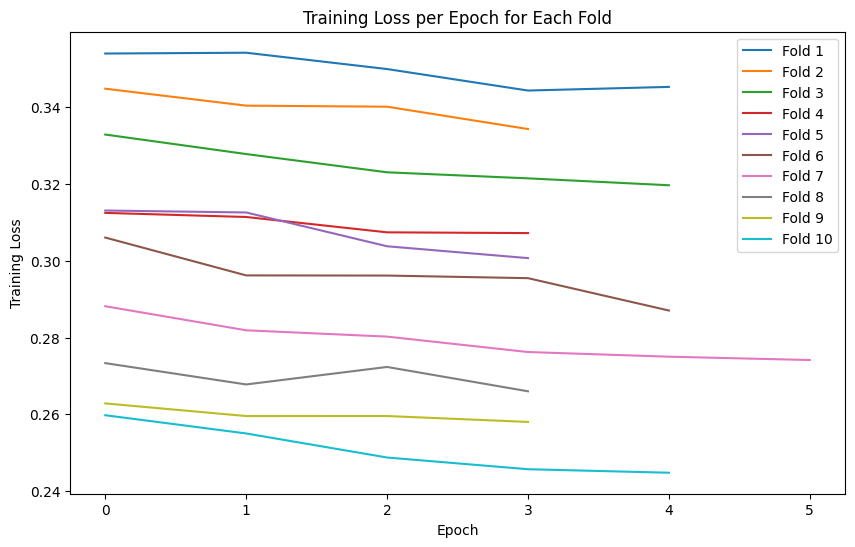

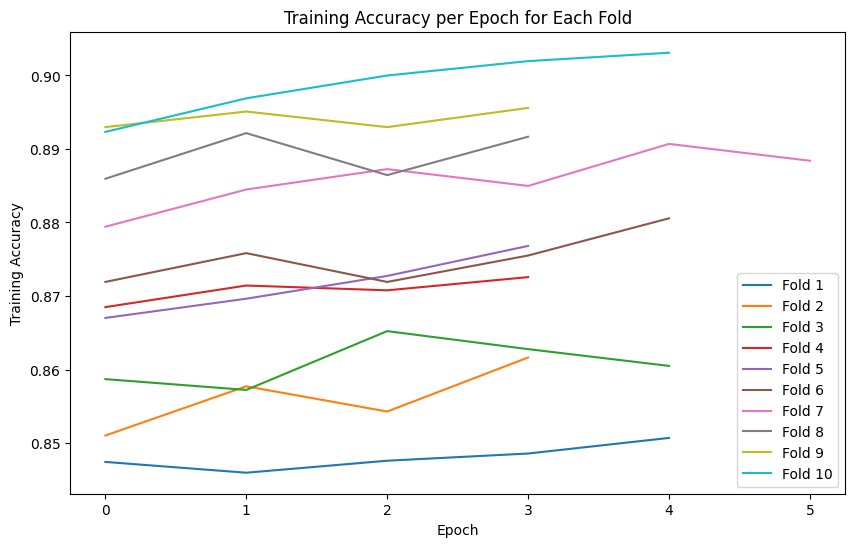

In [41]:
fold = 0

fold_accuracies = []
fold_f1_scores = []

train_loss_history = []
train_accuracy_history = []
for train_indices, val_indices in kf.split(combined_features):
    fold+=1
    print(f'fold = {fold}')
    X_train_fold = combined_features[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = combined_features[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    y_val_fold_tensor = tf.convert_to_tensor(y_val_fold, dtype=tf.float32)
    
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=10, 
        batch_size=32, 
        verbose=1,
        validation_data=(X_val_fold_tensor, y_val_fold_tensor),
        callbacks=CALLBACKS,
    )
    
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_binary)
    fold_accuracies.append(fold_accuracy)
    
    fold_f1_score = f1_score(y_val_fold, y_pred_val_binary)
    fold_f1_scores.append(fold_f1_score)
    
    train_loss_history.append(model_history.history['loss'])
    train_accuracy_history.append(model_history.history['accuracy'])
    
print("Cross-Validation Accuracies:", fold_accuracies)
print("Cross-Validation Scores:", fold_f1_scores)
print("Media Accuracy:", np.mean(fold_accuracies))
print("Media f1 score:", np.mean(fold_f1_scores))

plt.figure(figsize=(10, 6))
for fold_num, fold_loss in enumerate(train_loss_history):
    plt.plot(fold_loss, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Each Fold')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for fold_num, fold_accuracy in enumerate(train_accuracy_history):
    plt.plot(fold_accuracy, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Epoch for Each Fold')
plt.legend()
plt.show()

In [42]:
test_loss, test_accuracy = model.evaluate(X_test_tensor, y_test_tensor)

43/43 [==============================] - 0s 1ms/step - loss: 0.2125 - accuracy: 0.9104


In [43]:
def load_weights_from_hdf5(model, weight_path):
    model.load_weights(weight_path)
    return model

In [44]:
tlm_gran_weights_path = '../weights/tlm_peq_mult_weights.hdf5'
model = load_weights_from_hdf5(model, tlm_gran_weights_path)

fold = 1
Epoch 1/10
165/192 [========================>.....] - ETA: 0s - loss: 0.2516 - accuracy: 0.8981
Epoch 1: val_loss improved from 0.23587 to 0.22476, saving model to ../weights/tlm_peq_mult_weights.hdf5
192/192 [==============================] - 0s 2ms/step - loss: 0.2530 - accuracy: 0.8975 - val_loss: 0.2248 - val_accuracy: 0.9280
Epoch 2/10
160/192 [========================>.....] - ETA: 0s - loss: 0.2522 - accuracy: 0.8967
Epoch 2: val_loss did not improve from 0.22476
192/192 [==============================] - 0s 1ms/step - loss: 0.2502 - accuracy: 0.8979 - val_loss: 0.2276 - val_accuracy: 0.9163
Epoch 3/10
156/192 [=======================>......] - ETA: 0s - loss: 0.2458 - accuracy: 0.9026
Epoch 3: val_loss did not improve from 0.22476
192/192 [==============================] - 0s 1ms/step - loss: 0.2452 - accuracy: 0.9028 - val_loss: 0.2288 - val_accuracy: 0.9104
Epoch 4/10
160/192 [========================>.....] - ETA: 0s - loss: 0.2399 - accuracy: 0.9053
Epoch 4: val_lo

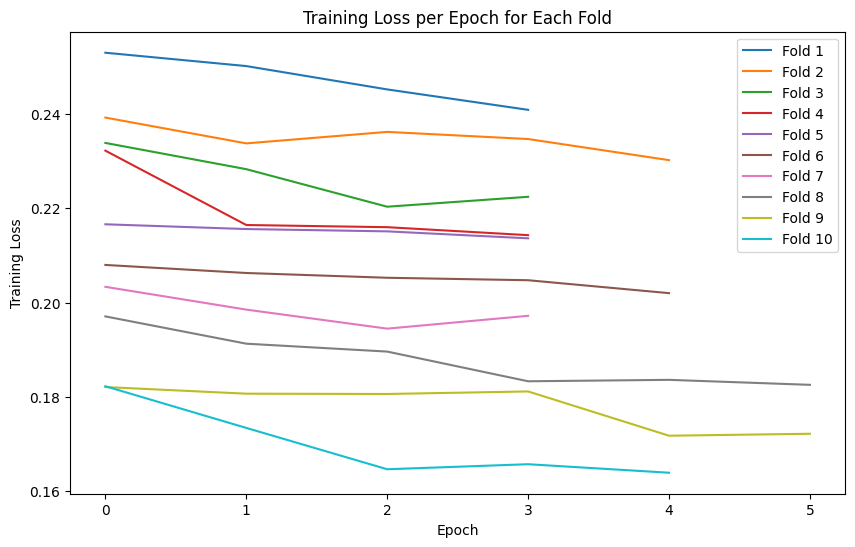

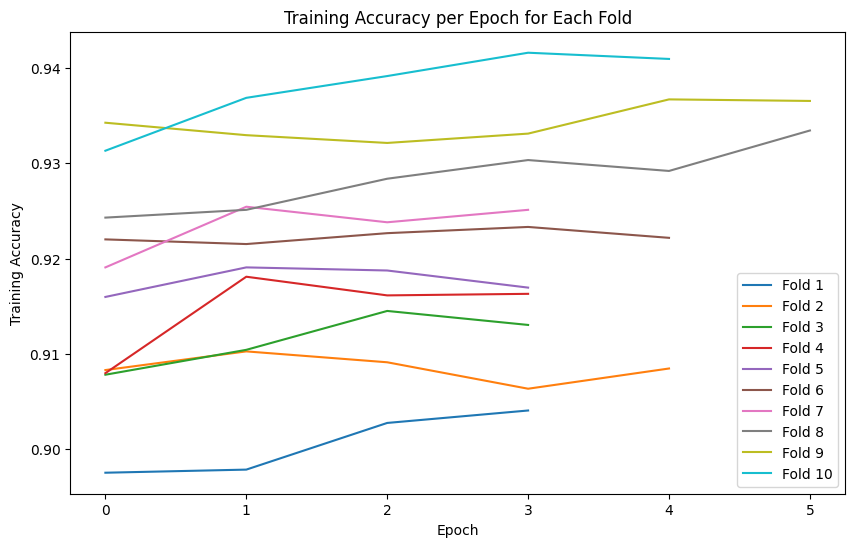

In [45]:
fold = 0

fold_accuracies = []
fold_f1_scores = []

train_loss_history = []
train_accuracy_history = []
for train_indices, val_indices in kf.split(combined_features):
    fold+=1
    print(f'fold = {fold}')
    X_train_fold = combined_features[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = combined_features[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    # Convertendo dados treino em tensores
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    
    # Convertendo dados de validacao em tensores
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    y_val_fold_tensor = tf.convert_to_tensor(y_val_fold, dtype=tf.float32)
    
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=10, 
        batch_size=32, 
        verbose=1,
        validation_data=(X_val_fold_tensor, y_val_fold_tensor),
        callbacks=CALLBACKS
    )
    
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_binary)
    fold_accuracies.append(fold_accuracy)
    
    fold_f1_score = f1_score(y_val_fold, y_pred_val_binary)
    fold_f1_scores.append(fold_f1_score)
    
    train_loss_history.append(model_history.history['loss'])
    train_accuracy_history.append(model_history.history['accuracy'])
    
print("Cross-Validation Accuracies:", fold_accuracies)
print("Cross-Validation Scores:", fold_f1_scores)
print("Media Accuracy:", np.mean(fold_accuracies))
print("Media f1 score:", np.mean(fold_f1_scores))

plt.figure(figsize=(10, 6))
for fold_num, fold_loss in enumerate(train_loss_history):
    plt.plot(fold_loss, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Each Fold')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for fold_num, fold_accuracy in enumerate(train_accuracy_history):
    plt.plot(fold_accuracy, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Epoch for Each Fold')
plt.legend()
plt.show()

In [46]:
test_loss, test_accuracy = model.evaluate(X_test_tensor, y_test_tensor)

43/43 [==============================] - 0s 947us/step - loss: 0.1241 - accuracy: 0.9662
